In [1]:
import os
import mido
import pretty_midi
import random

import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial.distance import cosine
from scipy.signal import convolve2d

from rich.progress import track

In [2]:
plt.style.use("dark_background")
random.seed(1)
DO_CENTER = True
delta_max = 55
dataset = os.path.join("..", "inputs", "all-fourbar")

In [3]:
def find_highest_lowest_notes_indices(midi_files):
    highest_note_g = -1
    lowest_note_g = 128
    delta_g = 0

    for file_path in midi_files:
        midi = mido.MidiFile(file_path)

        for track in midi.tracks:
            highest_note = -1
            lowest_note = 128

            for msg in track:
                if msg.type == "note_on" and msg.velocity > 0:
                    note = msg.note
                    if note > highest_note:
                        highest_note = note
                    if note < lowest_note:
                        lowest_note = note

            delta = highest_note - lowest_note

            if delta > delta_g:
                delta_g = delta
                lowest_note_g = lowest_note
                highest_note_g = highest_note

    return delta_g, (lowest_note_g, highest_note_g)


if delta_max is None:
    files = [os.path.join(dataset, f) for f in os.listdir(dataset)]
    delta_max, (lowest, highest) = find_highest_lowest_notes_indices(files)
    print(
        f"max delta = {delta_max} Lowest note index: {lowest}, Highest note index: {highest}"
    )

In [4]:
def process_and_pad(pr, h_max):
    non_zero_rows = np.where(np.any(pr > 0, axis=1))[0]

    lowest_note = non_zero_rows.min()
    highest_note = non_zero_rows.max()

    trimmed_pr = pr[lowest_note : highest_note + 1, :]

    current_h = trimmed_pr.shape[0]
    total_padding = max(h_max + 2 - current_h, 0)  # Ensure non-negative padding

    top_padding = total_padding // 2
    bottom_padding = total_padding - top_padding

    padded_pr = np.pad(
        trimmed_pr,
        ((top_padding, bottom_padding), (0, 0)),
        mode="constant",
        constant_values=0,
    )

    return padded_pr

In [5]:
def plot_prs(pr, bpr, title) -> None:
    plt.figure(figsize=(12, 6))
    plt.suptitle(title)

    plt.subplot(1, 2, 1)
    plt.imshow(pr, aspect="auto", origin="lower", cmap="magma")
    plt.title(f"piano roll {pr.shape}")
    plt.xlabel("time (ms)")
    plt.ylabel("MIDI note number")

    plt.subplot(1, 2, 2)
    plt.imshow(bpr, aspect="auto", origin="lower", cmap="magma")
    plt.title(f"downsampled {bpr.shape}")
    plt.xlabel("")
    plt.ylabel("")

    plt.tight_layout()
    plt.show()

In [6]:
def blur_pr(midi: pretty_midi.PrettyMIDI):
    pr = midi.get_piano_roll()
    if DO_CENTER:
        pr = process_and_pad(pr, delta_max)
    filter = np.full((3, 3), 0.5)
    width = 64
    height = int(pr.shape[0] / 4)
    small_img = cv2.resize(pr, (width, height), interpolation=cv2.INTER_AREA)

    return convolve2d(small_img, filter)

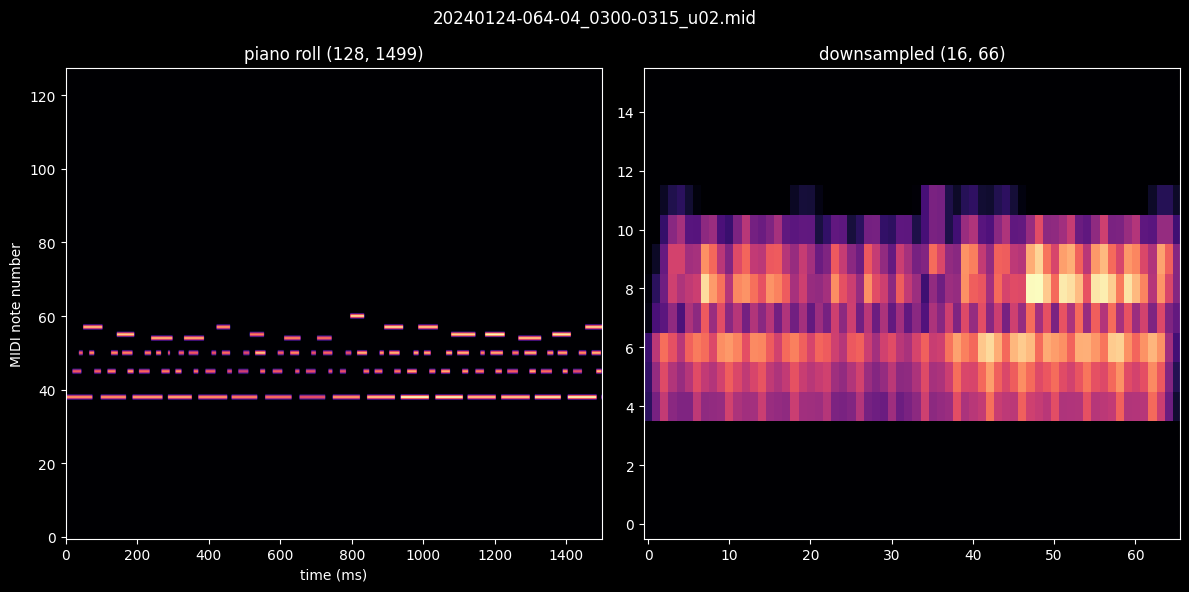

In [12]:
all_files = os.listdir(dataset)
random.shuffle(all_files)

main_file = all_files[0]
main_base_file = main_file.split("_")[0]
main_midi_path = os.path.join(dataset, main_file)
midi = pretty_midi.PrettyMIDI(main_midi_path)
main_blur = blur_pr(midi)

plot_prs(midi.get_piano_roll(), main_blur, main_file)

In [13]:
top_ten = [
    ["None", 0.0],
    ["None", 0.0],
    ["None", 0.0],
    ["None", 0.0],
    ["None", 0.0],
    ["None", 0.0],
    ["None", 0.0],
    ["None", 0.0],
    ["None", 0.0],
    ["None", 0.0],
]

for test_midi_file in track(
    all_files, "calculating similarities...", total=len(all_files)
):
    # for test_midi_file in all_files:
    test_base_file = test_midi_file.split("_")[0]
    if main_base_file == test_base_file:
        continue

    test_midi_path = os.path.join(dataset, test_midi_file)
    test_midi = pretty_midi.PrettyMIDI(test_midi_path)
    test_blur = blur_pr(test_midi)

    # plot_prs(test_midi.get_piano_roll(), test_blur, test_midi_file)

    # check cosine distance
    similarity = 1 - cosine(main_blur.flatten(), test_blur.flatten())
    smallest_value = float("inf")
    smallest_index = None
    for i, (filename, sim) in enumerate(top_ten):
        added_base_files = [afn.split("_")[0] for afn, _ in top_ten]
        if (
            sim < similarity
            and sim < smallest_value
            and test_base_file not in added_base_files
        ):
            smallest_value = sim
            smallest_index = i
    if smallest_index is not None:
        top_ten[smallest_index] = [test_midi_file, similarity]

Output()

In [14]:
new_ttcs = sorted(top_ten, key=lambda x: x[1], reverse=True)  # descending similarities
print(new_ttcs)

[['20240213-100-05_0163-0172_d03.mid', 0.9047905874512008], ['20240122-055-04_0157-0174_u04.mid', 0.8675203679665396], ['20240124-064-03_0360-0375_d03.mid', 0.8674526169589113], ['20240213-100-02_0153-0163_u05.mid', 0.8626252843848562], ['20240121-070-04_0397-0411_u04.mid', 0.8503831566077515], ['20240227-076-01_0341-0353_u01.mid', 0.8495857072677313], ['20240117-064-01_0090-0105_u01.mid', 0.8470829104537466], ['20240123-070-04_0617-0630_u04.mid', 0.844973732395658], ['20240122-055-01_0261-0279_u06.mid', 0.8417902036101207], ['20240123-070-07_0768-0781_u04.mid', 0.8416676172111839]]


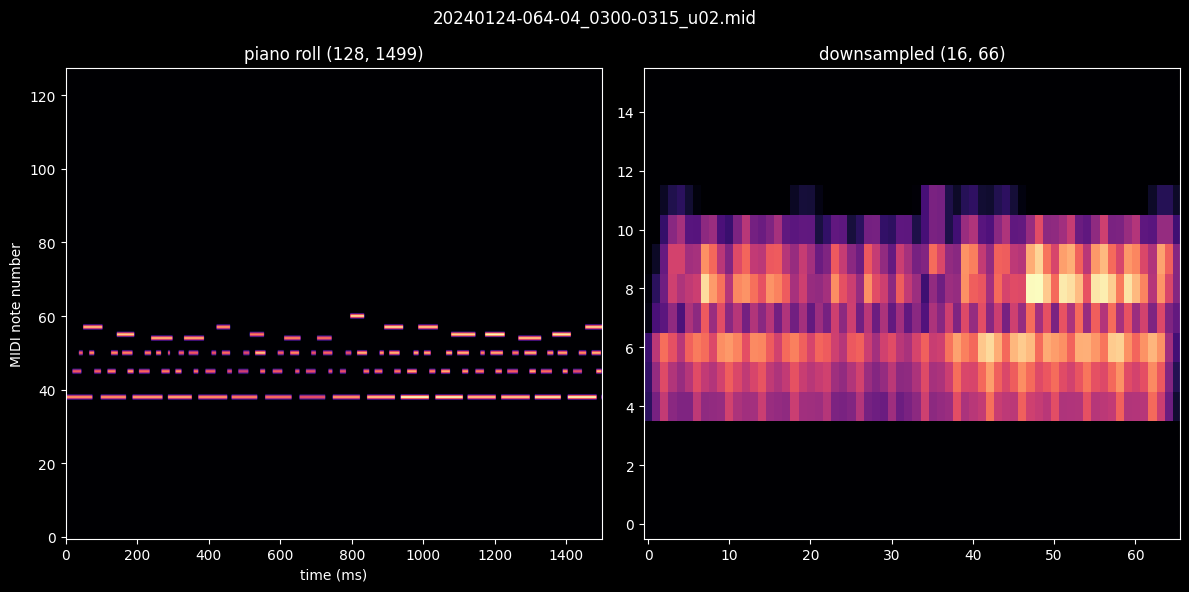

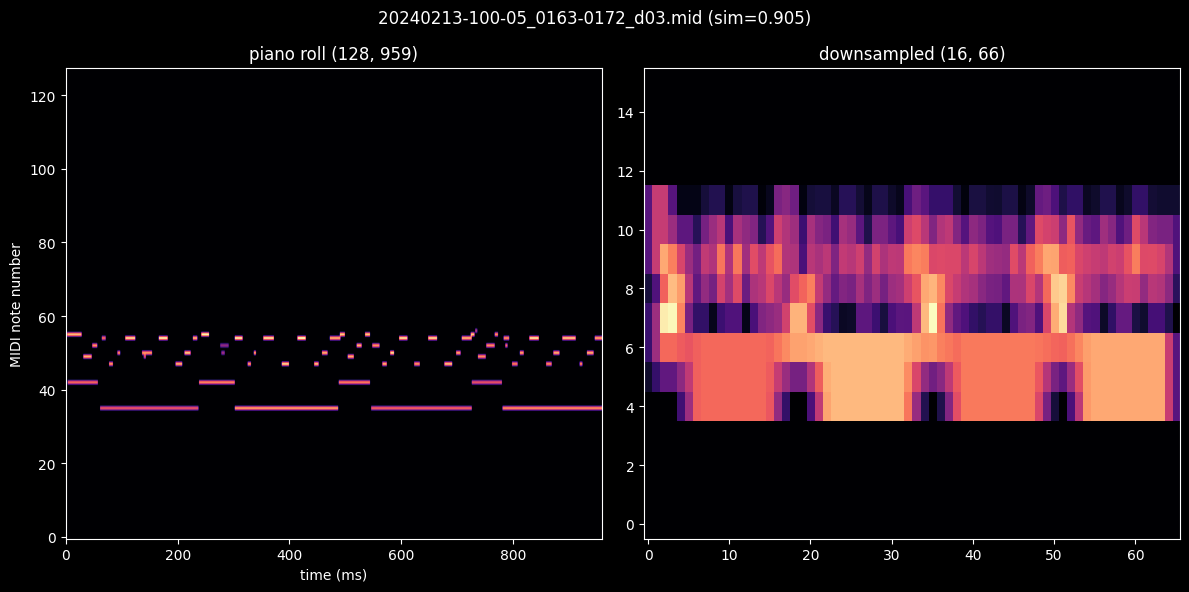

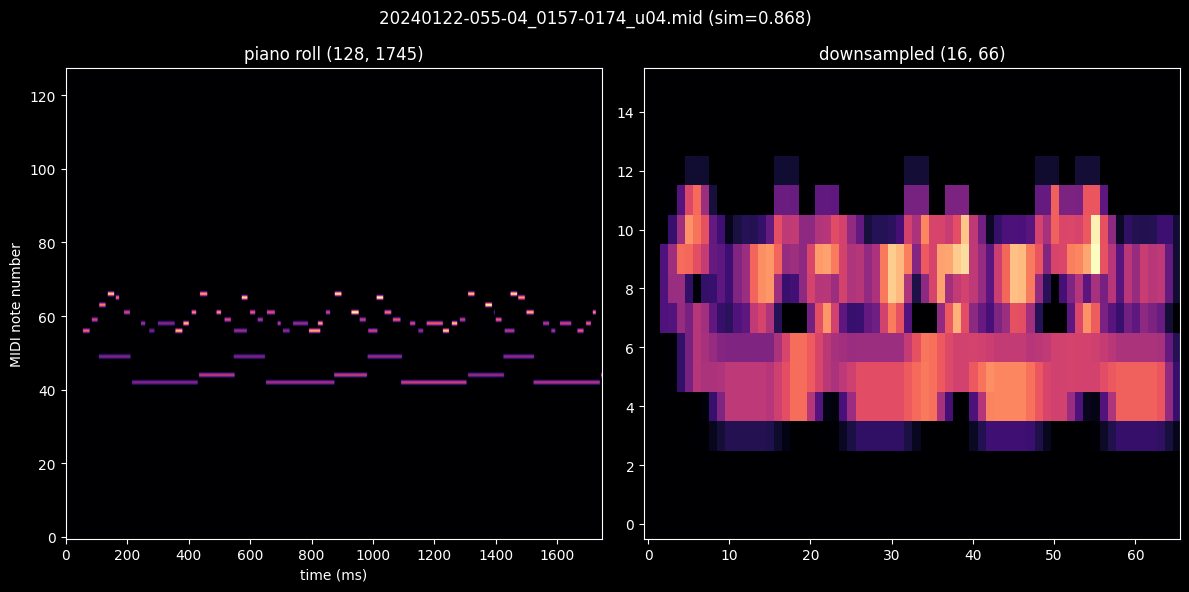

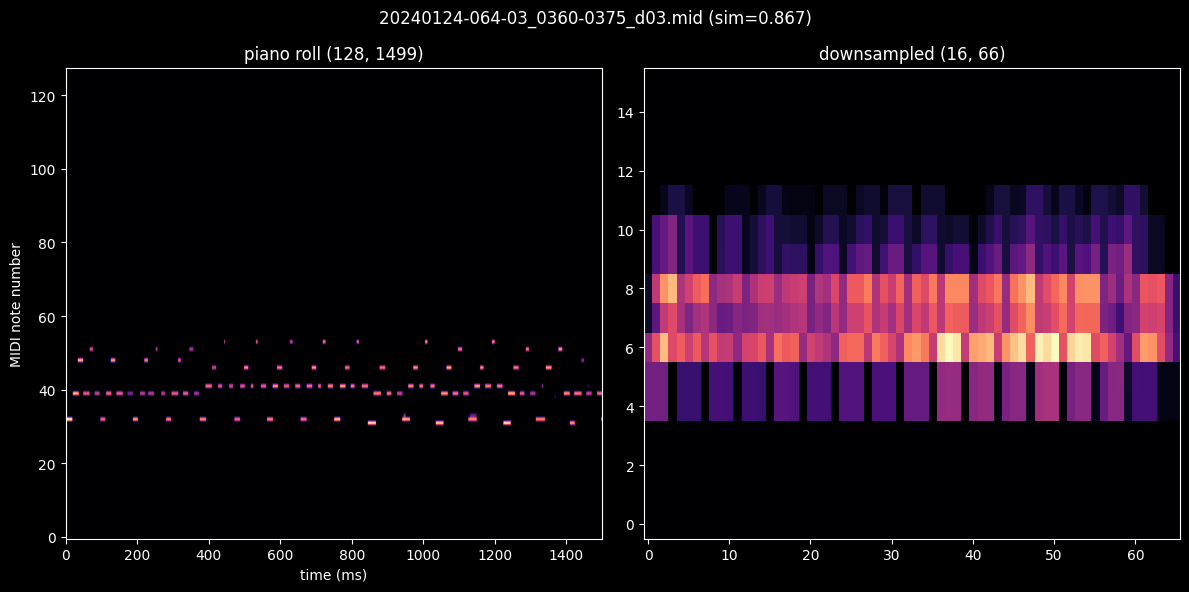

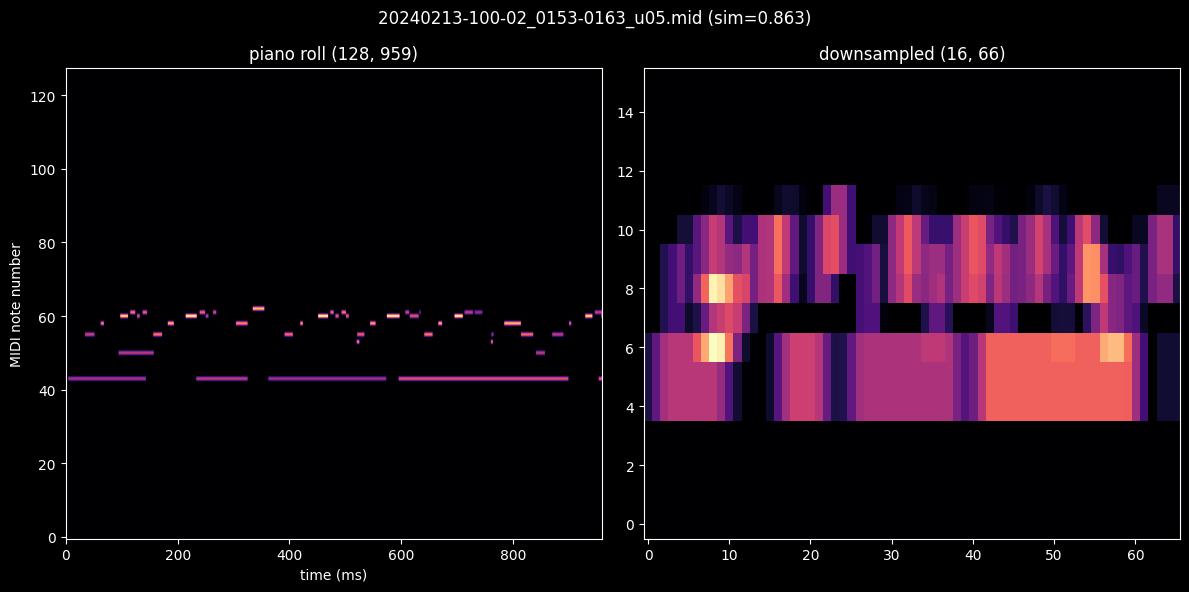

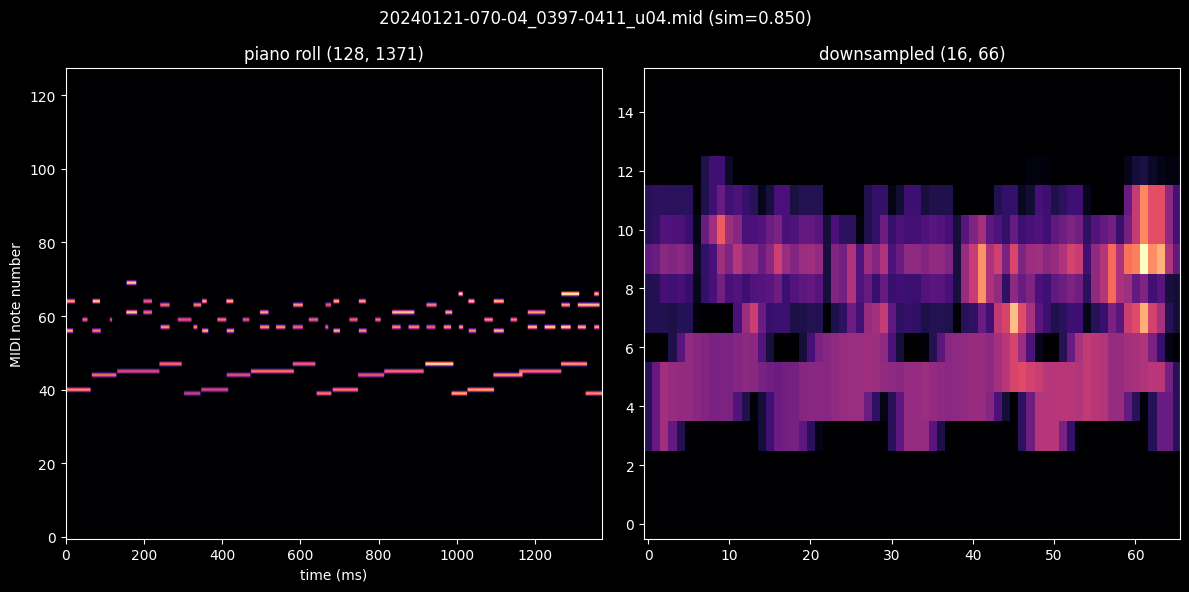

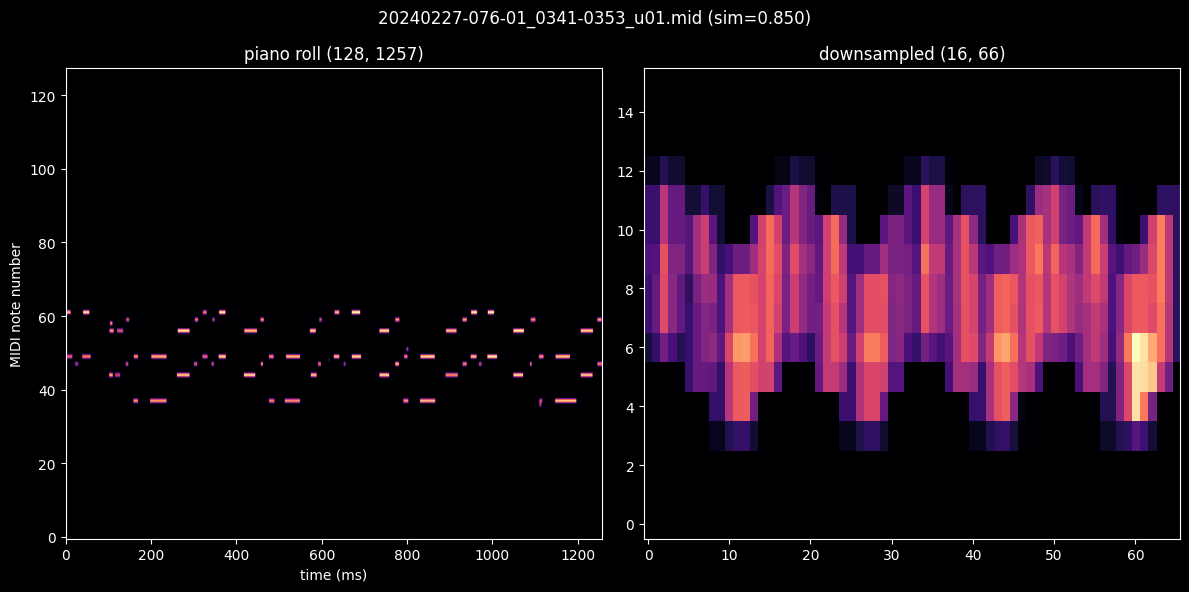

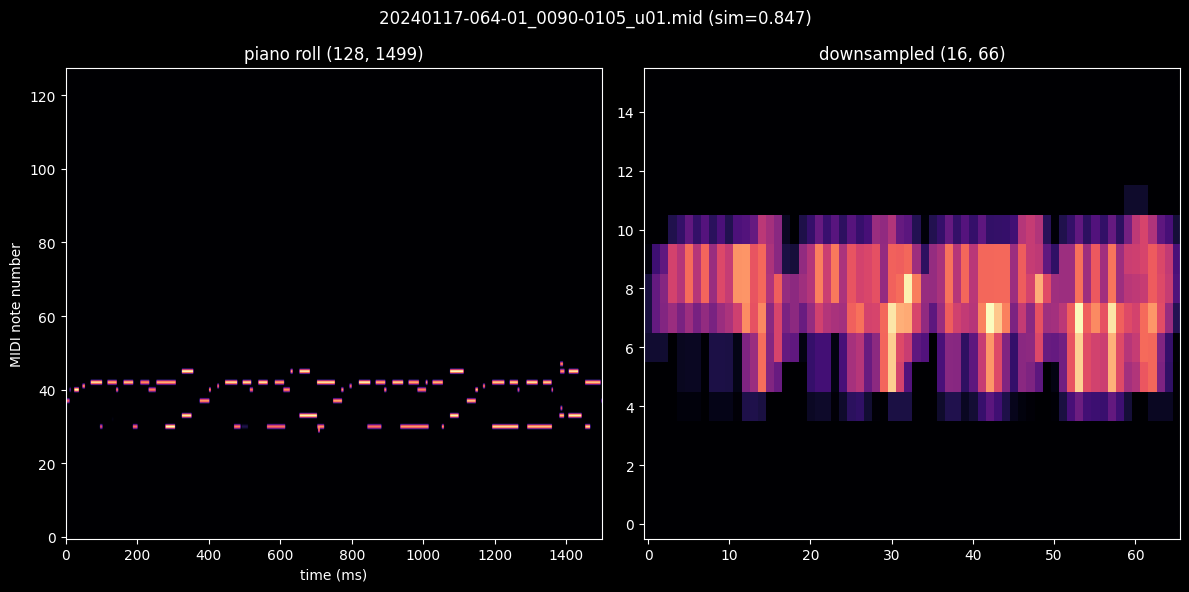

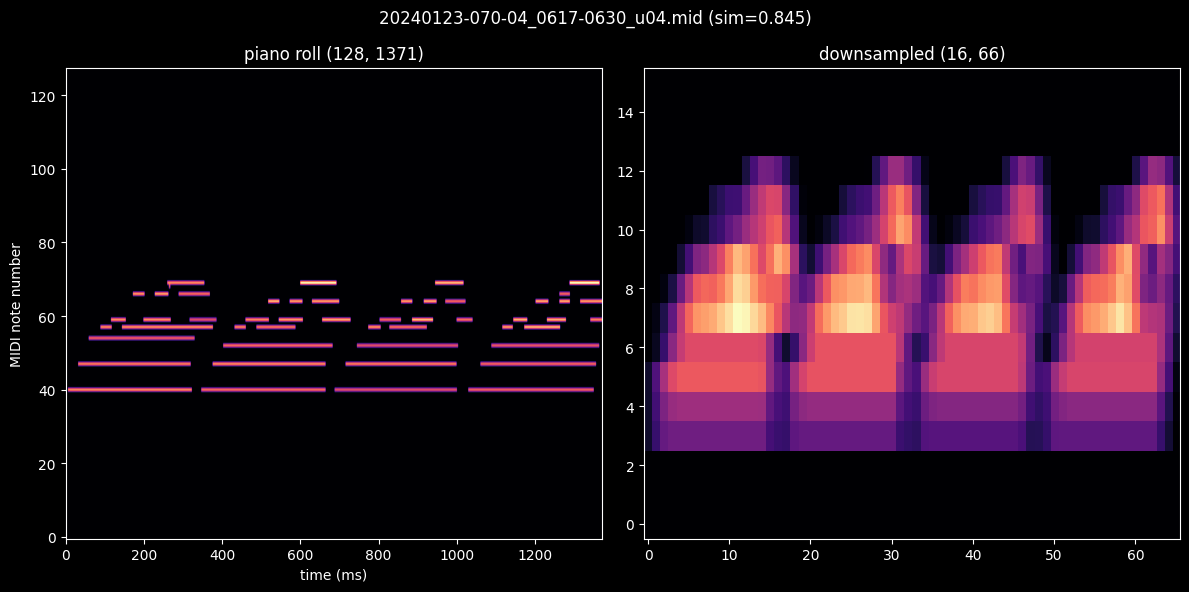

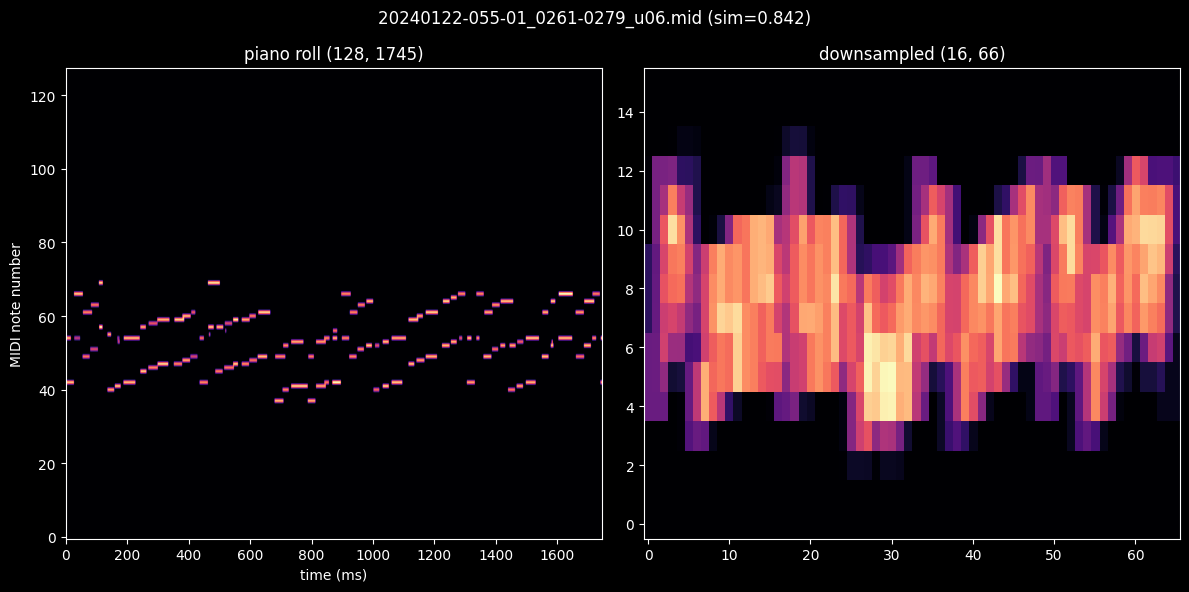

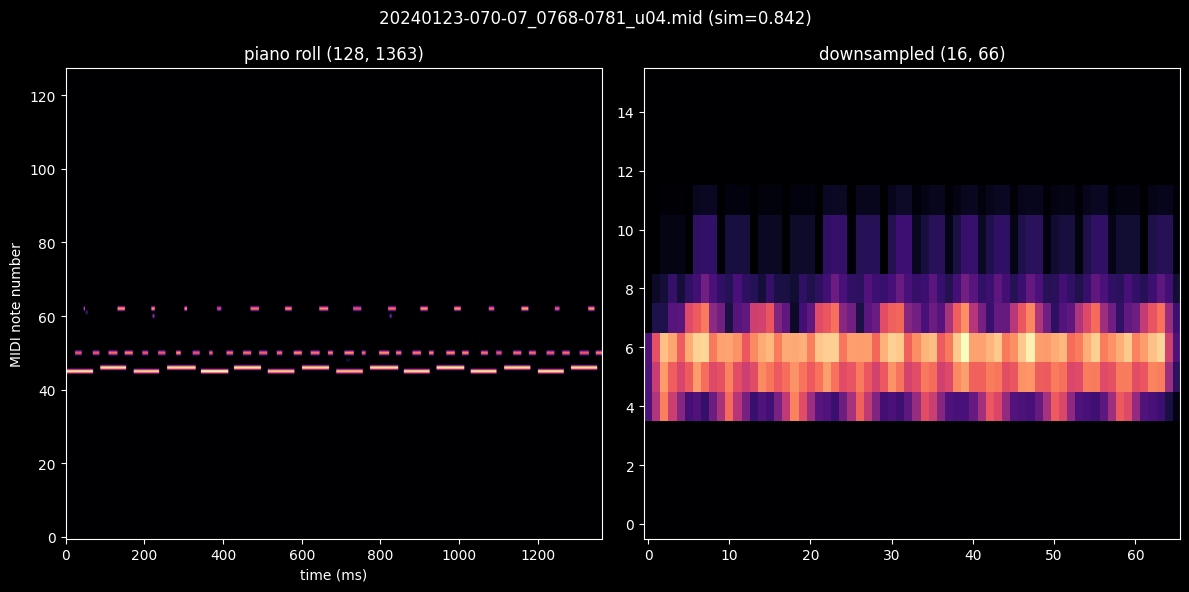

In [17]:
plot_prs(midi.get_piano_roll(), main_blur, main_file)

with mido.open_output("Disklavier") as output:  # type: ignore
    for message in mido.MidiFile(main_midi_path).play():
        output.send(message)

for file, sim in new_ttcs:
    fp = os.path.join(dataset, file)

    playing_pm = pretty_midi.PrettyMIDI(fp)
    plot_prs(
        playing_pm.get_piano_roll(), blur_pr(playing_pm), f"{file} (sim={sim:.03f})"
    )

    with mido.open_output("Disklavier") as output:  # type: ignore
        for message in mido.MidiFile(fp).play():
            output.send(message)